In [1]:
import sys
base_path = 'C:\\github\\aide-analysis'
sys.path.append(base_path)

from core.config import Config
config = Config()
config.RAWDATA_PATH

# 사전처리
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import glob
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
warnings.filterwarnings(action='ignore')

# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

# Pandas Float 자릿수 표시 제한
pd.options.display.float_format = '{:.2f}'.format

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

### 1. 거래량과 미분양 정말로 관계가 없을까?

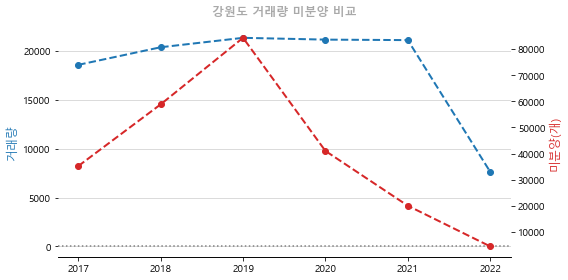

In [88]:
from src.bigquery import bigquery_client, bigquery
from src.sql import DatabaseHandler
import datetime
bq = bigquery_client

# 아파트 전세 테이블 연도별 거래량
sql = f"""
SELECT contractDate, 
       count(*) AS cnt
FROM `aidepartners.aide.transaction_price_apartment_rent`
WHERE pnuCode LIKE '42%'
GROUP BY contractDate
ORDER BY contractDate ASC
"""
df = bq.query(sql).to_dataframe()
transaction = df.copy()

# 타입변경
transaction['contractDate'] = pd.to_datetime(transaction['contractDate'],format = '%Y-%m-%d')

# 연도 컬럼 생성
transaction['year'] = transaction['contractDate'].dt.year

# 인덱스 설정
transaction = pd.DataFrame(transaction.groupby('year')['cnt'].sum()).reset_index()


# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""

SELECT year, SUM(unsold) FROM aide.unsold_sigungu
WHERE sigunguName !='계'
	  AND sidoCode = '42'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()

# 거래량 데이터와 연도 통일
transaction = transaction.loc[6:,['year','cnt']].reset_index(drop = True)

# 컬럼명 변경
unsold = unsold.rename(columns = {'SUM(unsold)':'unsold'})


# Merge
dataset = pd.merge(transaction, unsold,on = 'year', how = 'inner')

# Visualization
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(dataset['year'],dataset['cnt'],"o--",label = '거래량',lw=2, color = 'tab:blue')
ax.set_ylabel('거래량', fontsize = 12, color = 'tab:blue')

ax2 = ax.twinx()
ax2.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=2, color = 'tab:red')
ax2.set_ylabel('미분양(개)', fontsize = 12, color = 'tab:red')

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title("강원도 거래량 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[['left','top', 'right']].set_visible(False)

fig.tight_layout()
plt.show()

1. 이론적으로 거래량과 미분양은 상관관계가 별로 없다라는것을 시각화를 통해 확인

2. 미분양은 공급량과의 관계가 당연히 많지 않을까?(주택공급과 관련된 데이터 부재 -> 주거용 건축물 착공데이터 탐색)

3. 2019년 서울시 미분양이 많았는데 왜 그럴까?

### 2. 미분양과 전세증감률 관계

#### 확인해야할 사항
- 전세증감에서 year별로 그룹핑해서 SUM이 올바른것인가?
- 정규화의 방법

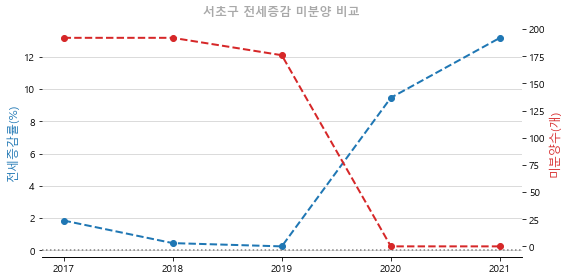

In [98]:
# 미분양과 전세증감률 관계

from src.openapi import KakaoLocalAPI as kakao
from src.bigquery import bigquery_client, bigquery
from src.sql import DatabaseHandler
import datetime

# DB, Bigquery
bq = bigquery_client
db = DatabaseHandler()

# 주소정보
add_list = [
            "잠원동22-10",
            "경기도 용인시 기흥구 보정로 87",
            "경기도 수원시 팔달구 인계동 1111",
            "세종특별자치시 한누리대로 2130 세종특별시청",
            "탄현동 121",
            "지포리 138",
            "신안리 183",
            "홍제동 1037",
            "장락동 1029",
            "읍내동 25-6",
            "남장리 515",
            "도량동 222",
            "원리 892",
            "달천동 1-5",
            "서문리 218-11",
            "북변리 179-1",
            "주청리 120-4",
            "송월동 660"
           ]

# 카카오 API
docs = kakao.search_address(add_list[0])


# 파싱정보 업데이트 
sidoCode = docs["documents"][0]["address"]["h_code"][:2] # 시도 코드
sigunguCode = docs["documents"][0]["address"]["h_code"][:5] # 시군구 코드
sido_ = docs["documents"][0]["address"]["region_1depth_name"] # 시도 명
sigungu_ = docs["documents"][0]["address"]["region_2depth_name"] # 시군구 명
if sigungu_ == "":
    sigungu_ = sido_ + "(시군구 존재 X)"
    

# 전세증감률 연도별 집계테이블 로드
sql= f"""
SELECT YEAR(date) AS year, 
       SUM(jeonseChangeRate) AS jeonseChangeRate
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode = {sigunguCode}
GROUP BY YEAR(date) 
order by YEAR(date)
"""
kb = db.read_table(sql)


# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""
SELECT year, 
       SUM(unsold) AS unsold 
FROM aide.unsold_sigungu
WHERE sigunguName !='계'
      AND sigunguCode = {sigunguCode}
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()


# Merge( 전세증감 + 미분양)
dataset = pd.merge(kb, unsold, on = 'year', how = 'inner')

# 2021년으로 범위 수정
dataset = dataset.iloc[:-1]



# 시각화
fig, ax = plt.subplots(figsize = (8,4))

# 전세증감율 plot
ax.set_ylabel('전세증감률(%)',fontsize = 12, color = 'tab:blue')
ax.plot(dataset['year'],dataset['jeonseChangeRate'],"o--",label = '전세증감률',lw=2,color = 'tab:blue')

# 미분양 plot
ax2 = ax.twinx()
ax2.set_ylabel('미분양수(개)', fontsize = 12, color = 'tab:red')
ax2.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=2,color = 'tab:red')



# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title(f"{sigungu_} 전세증감 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[["left", "top", "right"]].set_visible(False)

# x축 눈금 변환
plt.xticks([2017,2018,2019,2020,2021],[2017,2018,2019,2020,2021])

fig.tight_layout()
plt.show()

#### 한계
1. kb데이터는 일부 시군구가 빠져있으며 그들의 표본추출방식이 따로 존재하기 때문에 해당지표만으로는 신뢰가 부족할 수도 있음.

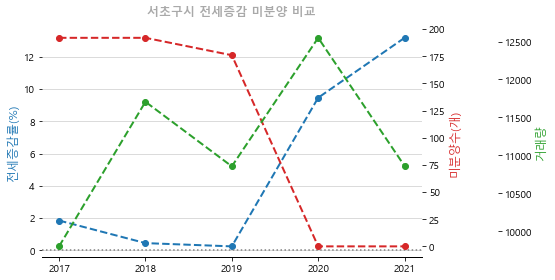

In [89]:
# 거래량 미분양, 전세증감 


from src.openapi import KakaoLocalAPI as kakao
from src.bigquery import bigquery_client, bigquery
from src.sql import DatabaseHandler
import datetime



bq = bigquery_client
db = DatabaseHandler()
add_list = [
    "잠원동22-10",
    "경기도 용인시 기흥구 보정로 87",
    "경기도 수원시 팔달구 인계동 1111",
    "세종특별자치시 한누리대로 2130 세종특별시청",
    "탄현동 121",
    "지포리 138",
    "신안리 183",
    "홍제동 1037",
    "장락동 1029",
    "읍내동 25-6",
    "남장리 515",
    "도량동 222",
    "원리 892",
    "달천동 1-5",
    "서문리 218-11",
    "북변리 179-1",
    "주청리 120-4",
    "송월동 660"
]

docs = kakao.search_address('잠원동22-10')


# 시도/ 시군구/ 행정동 코드 추출
sidoCode = docs["documents"][0]["address"]["h_code"][:2]
sigunguCode = docs["documents"][0]["address"]["h_code"][:5]


# 시도/ 시군구/ 행정동 코드 추출
sido_ = docs["documents"][0]["address"]["region_1depth_name"]
sigungu_ = docs["documents"][0]["address"]["region_2depth_name"]
if sigungu_ == "":
    sigungu_ = sido_ + "(시군구 존재 X)"
    
# sidoCode ='11'
# sido_ = '서울'



#=================================================================================================================
#
#                                                     MAIN CODE
#
#=================================================================================================================


# 아파트 전세 테이블 연도별 거래량
sql = f"""
SELECT contractDate, 
       count(*) AS cnt
FROM `aidepartners.aide.transaction_price_apartment_rent`
WHERE pnuCode LIKE '{sigunguCode}%'
GROUP BY contractDate
ORDER BY contractDate ASC
"""
df = bq.query(sql).to_dataframe()
transaction = df.copy()


# 타입변경
transaction['contractDate'] = pd.to_datetime(transaction['contractDate'],format = '%Y-%m-%d')

# 연도 컬럼 생성
transaction['year'] = transaction['contractDate'].dt.year

# 인덱스 설정
transaction = pd.DataFrame(transaction.groupby('year')['cnt'].sum()).reset_index()
transaction = transaction.iloc[6:]



sql= f"""
SELECT YEAR(date) AS year, SUM(jeonseChangeRate) AS jeonseChangeRate
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode = {sigunguCode}
GROUP BY YEAR(date) 
order by YEAR(date)
"""
kb = db.read_table(sql)
#kb=kb.iloc[9:]


# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""

SELECT year, SUM(unsold) AS unsold 
FROM aide.unsold_sigungu
WHERE sigunguName !='계'
      AND sigunguCode = '{sigunguCode}'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()
#unsold['unsold'] = unsold['unsold'].apply(lambda x: round((x/unsold['unsold'].iloc[0])-1,2))

dataset = pd.merge(kb, unsold, on = 'year', how = 'inner')
dataset = pd.merge(dataset, transaction, on = 'year', how = 'inner')
dataset= dataset.iloc[:-1]

# Visualization
fig, ax = plt.subplots(figsize = (8,4))

ax.set_ylabel('전세증감률(%)',fontsize = 12, color = 'tab:blue')
ax.plot(dataset['year'],dataset['jeonseChangeRate'],"o--",label = '전세증감률',lw=2,color = 'tab:blue')


ax2 = ax.twinx()



ax2.set_ylabel('미분양수(개)', fontsize = 12, color = 'tab:red')
ax2.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=2,color = 'tab:red')

ax3 = ax.twinx()
ax3.set_ylabel('거래량',fontsize = 12, color = 'tab:green')
ax3.plot(dataset['year'],dataset['cnt'],'o--', label = '거래량', lw = 2, color = 'tab:green')

# 세번째 축 위치 조정
ax3.spines["right"].set_position(("axes", 1.2))

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title(f"{sigungu_}시 전세증감 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[["left", "top", "right"]].set_visible(False)
ax3.spines[["left", "top", "right"]].set_visible(False)

# x축 눈금 변환
plt.xticks([2017,2018,2019,2020,2021],[2017,2018,2019,2020,2021])

fig.tight_layout()
plt.show()

### 3. (미분양과 매매증감률) 

### 4. 매매증감 전세증감 비교

### 5. 주택인허가 활용(API) -> 3번진행 후 진행

In [39]:
# 주택인허가 데이터 OPEN API
import requests
import json
import xmltodict

endPoint = "http://apis.data.go.kr/1611000/HsPmsService"
key = ""
operationName = "getHpBasisOulnInfo"
sigunguCode = '11710'
numOfRows = '10'
pageNo = '1'

url = f"{endPoint}/{operationName}?sigunguCd={sigunguCode}&bjdongCd={bdongCode}&numOfRows={numOfRows}&pageNo={pageNo}&ServiceKey={key}"
print(url)

result = xmltodict.parse(requests.get(url).text)
result = json.loads(json.dumps(result))
result 

http://apis.data.go.kr/1611000/HsPmsService/getHpBasisOulnInfo?sigunguCd=11710&bjdongCd=10300&numOfRows=10&pageNo=1&ServiceKey=Hq2wnub/iZKqw9lRb26b35ZxOJG03vwhhrirESSfYKsNYdEsj0li7vQaFogysBhKvyHtfXCxBvzY8VLFxz8ZFQ==


{'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL SERVICE.'},
  'body': {'items': {'item': [{'apprvDay': '20080808',
      'bjdongCd': '10300',
      'bldNm': None,
      'block': None,
      'bun': '0508',
      'crtnDay': '20120218',
      'demolEndDay': None,
      'demolExtngDay': None,
      'demolExtngGbCd': None,
      'demolExtngGbCdNm': None,
      'demolStrtDay': None,
      'ji': '0000',
      'lot': None,
      'mainBldCnt': '0',
      'mgmHsrgstPk': '11710-100006240',
      'platGbCd': '0',
      'platPlc': '서울특별시 송파구 풍납동 508번지',
      'purpsCd': None,
      'purpsCdNm': None,
      'rnum': '1',
      'sigunguCd': '11710',
      'splotNm': None,
      'stcnsDay': None,
      'stcnsSchedDay': None,
      'strctCd': None,
      'strctCdNm': None,
      'totArea': '0',
      'totHhldCnt': '0',
      'useInsptDay': None,
      'useInsptSchedDay': None},
     {'apprvDay': '19951226',
      'bjdongCd': '10300',
      'bldNm': '풍납동 삼화재건축',
      'block': None,
   

In [56]:
result['response']['body']['items']['item'][0]

{'apprvDay': '20080808',
 'bjdongCd': '10300',
 'bldNm': None,
 'block': None,
 'bun': '0508',
 'crtnDay': '20120218',
 'demolEndDay': None,
 'demolExtngDay': None,
 'demolExtngGbCd': None,
 'demolExtngGbCdNm': None,
 'demolStrtDay': None,
 'ji': '0000',
 'lot': None,
 'mainBldCnt': '0',
 'mgmHsrgstPk': '11710-100006240',
 'platGbCd': '0',
 'platPlc': '서울특별시 송파구 풍납동 508번지',
 'purpsCd': None,
 'purpsCdNm': None,
 'rnum': '1',
 'sigunguCd': '11710',
 'splotNm': None,
 'stcnsDay': None,
 'stcnsSchedDay': None,
 'strctCd': None,
 'strctCdNm': None,
 'totArea': '0',
 'totHhldCnt': '0',
 'useInsptDay': None,
 'useInsptSchedDay': None}